#     Gaussian Process Regression: Hand motion to URDF joints

Let's begin with importing the required libraries:

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared
)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

# for saving data files
import pandas as pd

# for formatting images
from PIL import Image 

In [13]:
# Initial parameters: vary these to control how many gestures (sets) are used for GPR training, which sets/runs
#  are excluded, and whether DTW is used

# Hard coded from DTW python file: endpt = -100 (future runs will save endpt, so you can extract it from the file)
initialtruncate = -100

doDTW = True
#Normally, we leave out one demonstration (run) and use it for cross-validation. You can also leave out one entire
# gesture (set) and find the error in predicting an unseen gesture
excludeSetNotRun = True

alphaval = 1e-2
optimum_alphas_setskip = [1e-1,1e-0, 1e-1, 1e-3, 1e-3, 1e0, 1e-5, 1e-2, 1e-0]
optimum_alphas_runskip = [1e-2,1e-3, 1e-1, 1e-3, 1e-2, 1e-2, 1e-1, 1e-3, 1e-3]

endpt = -50 # Empirically determined end of data (cutting off trailing ends)
stepsize = 10

setskipval = 0
# runskipval = 1 # Identify the run that will serve as the test dataset
set_begin = 0
setrange = 9

In [22]:
if excludeSetNotRun:
    ## Different sort of run: exclude one gesture (set)
    runskipval = 11     # Choose a value high enough that no runs will be excluded
    
    for setskipval in range(0,9):
        # Collect training data from all sets except the skipped one
        alphaval = optimum_alphas_setskip[setskipval]
        if (set_begin==setskipval):            
            x,y = load_data(set_begin+1, setskipval, runskipval, doDTW, endpt, excludeSetNotRun)
            for set_num in range(set_begin+2,setrange):
                x_temp, y_temp = load_data(set_num, setskipval, runskipval, doDTW, endpt, excludeSetNotRun)
                x = np.vstack((x, x_temp))
                y = np.vstack((y, y_temp))
        else:
            x,y = load_data(set_begin, setskipval, runskipval, doDTW, endpt, excludeSetNotRun)
            for set_num in range(set_begin,setrange):
                if (set_num==setskipval):
                    continue
                else:
                    x_temp, y_temp = load_data(set_num, setskipval, runskipval, doDTW, endpt, excludeSetNotRun)
                x = np.vstack((x, x_temp))
                y = np.vstack((y, y_temp))
                   
        # Collect test data from the skipped set
        x_star, y_test = test_set(setskipval, 1, doDTW)
            
#         for run in range(2,11): # Note that you could test on only one run of the excluded set, instead of all of them
#             x_star_temp, y_test_temp = test_set(setskipval, run, doDTW)
#             x_star = np.vstack((x_star,x_star_temp))
#             y_test = np.vstack((y_test, y_test_temp))

        #Which alpha do we choose?
        x_pos_pred_mean, x_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 0)
        y_pos_pred_mean, y_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 1)
        z_pos_pred_mean, z_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 2)
        x_rot_pred_mean, x_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 3)
        y_rot_pred_mean, y_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 4)
        z_rot_pred_mean, z_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 5)

        pred_vals = np.vstack((x_pos_pred_mean, y_pos_pred_mean, z_pos_pred_mean, x_rot_pred_mean, y_rot_pred_mean, z_rot_pred_mean)).T
        std_vals  = np.vstack((x_pos_pred_std , y_pos_pred_std , z_pos_pred_std , x_rot_pred_std , y_rot_pred_std , z_rot_pred_std )).T

        plot_error(pred_vals, std_vals, y_test, setskipval, runskipval, alphaval, excludeSetNotRun)
        save_pred(pred_vals, std_vals, y_test, setskipval, runskipval, alphaval, excludeSetNotRun)
#         plot_prediction(pred_vals, std_vals, y_test, setskipval, runskipval, alphaval, setrange, excludeSetNotRun)
        plot_envelope(y, y_test, pred_vals, setskipval)

        error_data = np.load('EEFF_Pred_and_avgError_for_TrainAllbut'+str(setskipval)+'_alphaval_'+str(alphaval)+'.npz')    
        err_act = error_data['actual_error']
        print(setskipval)
        print(err_act)
else:
#     for alphaval in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]:
#         print('Alpha = '+str(alphaval))
        # Run a bunch of individual sets, doing leave-one-demonstration-out cross-validation for each
#         for set_num in range(set_begin, setrange):
        for set_num in range(0, 1):
            alphaval = optimum_alphas_runskip[set_num]
#             for runskipval in range(1,11):
            for runskipval in range(5,6):
                print('runskipval = '+str(runskipval))
                x,y = load_data(set_num, set_num, runskipval, doDTW, endpt, excludeSetNotRun)
                x_star, y_test = test_set(set_num, runskipval, doDTW)

                x_pos_pred_mean, x_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 0)
                y_pos_pred_mean, y_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 1)
                z_pos_pred_mean, z_pos_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 2)
                x_rot_pred_mean, x_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 3)
                y_rot_pred_mean, y_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 4)
                z_rot_pred_mean, z_rot_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 5)

                pred_vals = np.vstack((x_pos_pred_mean, y_pos_pred_mean, z_pos_pred_mean, x_rot_pred_mean, y_rot_pred_mean, z_rot_pred_mean)).T
                std_vals  = np.vstack((x_pos_pred_std , y_pos_pred_std , z_pos_pred_std , x_rot_pred_std , y_rot_pred_std , z_rot_pred_std )).T

                plot_error(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, excludeSetNotRun)
                save_pred(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, excludeSetNotRun)
                plot_prediction(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, setrange, excludeSetNotRun)

            #Note: technically, to get a good error analysis, you should repeat 10 times with each run taking a turn being left out for cross-validation
            err_est = 0
            err_act = 0

            for i in range(1,11):
            #     error_data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
                error_data = np.load('EEFF_error_avg_for_Train'+str(set_num)+'_leaveoneout_'+str(runskipval)+'_alphaval_'+str(alphaval)+'.npz')    
#                 err_est = err_est + error_data['error_estimate']
                err_act = err_act + error_data['mse_error']
#             err_est = err_est/len(range(1,11))
            err_act = err_act/len(range(1,11))
            print('Set = '+str(set_num))
    #         print(err_est)
            print('Error = '+str(err_act))

0
0.19137930241977097
1
0.12987994047510434
2
0.1416187125682291
3
0.19826717215284456
4
0.13915741846458662
5
0.09488143928796165


C:\Users\jmoln\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00037059]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


6
0.2449602449014316
7
0.2842195668634905
8
0.13286408852881307


In [3]:
def load_data(set_num, setskipval, runskipval, doDTW, endpt, excludeSetNotRun):
    
    # Initialize data arrays
    x = np.array((0, 0, 0, 0, 0, 0))
    y = np.array((0, 0, 0, 0, 0, 0))

    if excludeSetNotRun:
        run_range = [6]
    else:
        run_range = range(1,11)
    for run in run_range: 
#         print('run = '+str(run))
        if excludeSetNotRun:
            skipcriteria = (set_num==setskipval)
        else:
            skipcriteria = (set_num==setskipval and run==runskipval)
        if skipcriteria: 
            continue
        else :
#             print("run="+str(run))
            # Use the commented line below when running on Ubuntu instead of Windows
#             data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
            data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")

            if doDTW:
                x_temp = np.hstack((data['hand_pos_aligned'][0:endpt:stepsize], data['hand_rot_aligned'][0:endpt:stepsize]))
                y_temp = np.hstack((data['end_eff_pos_aligned'][0:endpt:stepsize], data['end_eff_rot_aligned'][0:endpt:stepsize]))
                
            else: # Load non-DTW-aligned data
                x_temp = data['hand_data'][0:endpt+initialtruncate:stepsize,1:7]
                y_temp = data['end_eff_data'][0:endpt:stepsize,1:7]
#                 print(x_temp.shape)
#                 print(y_temp.shape)

            x = np.vstack((x,x_temp))
            y = np.vstack((y,y_temp))

    # Strip unnecessary starting row of zeros from x and y
    if (excludeSetNotRun and skipcriteria):
        return None, None
    else:
        x = x[1:-1]
        y = y[1:-1]
    
        return x, y

In [4]:
def test_set(set_num, runskipval, doDTW):
    # data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
    data_test = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(runskipval)+".npz")
    if doDTW:
        x_star = np.hstack((data_test['hand_pos_aligned'][0:endpt:stepsize], data_test['hand_rot_aligned'][0:endpt:stepsize]))
        y_test = np.hstack((data_test['end_eff_pos_aligned'][0:endpt:stepsize], data_test['end_eff_rot_aligned'][0:endpt:stepsize]))
    else:
        x_star = data_test['hand_data'][0:endpt+initialtruncate:stepsize,1:7]
        y_test = data_test['end_eff_data'][0:endpt:stepsize]
    
    return x_star, y_test

In [5]:
def GPR_joint_prediction(alphaval, x, y, x_star, joint):# Construction of Sklearn's Regression and Selection of the Kernel
    kernel = RBF(1,(1e-2,1e4)) # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2))   #Good length scale limits seem to lower bound at 0.1, 0.5, or 1.0
    
    gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
    gp_regressor.fit(x,y[:,joint])
#     print(f"RBF Lengthscale: {gp_regressor.kernel_}")
    J_pred_mean, J_pred_std = gp_regressor.predict(x_star, return_std=True)

    # df = pd.DataFrame(y_pred_mean)
    # df.to_csv('trained_endeff_mean.csv')
    # df = pd.DataFrame(y_pred_std)
    # df.to_csv('trained_endeff_std.csv')

    return J_pred_mean, J_pred_std

In [6]:
def plot_error(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, excludeSetNotRun):
    f = plt.figure(figsize=[17.0, 12.0])

    ax = f.add_subplot(111)
    # labels = ('X','Y','Z')
    labels = ('X Position','Y Position','Z Position', 'X Orientation', 'Y Orientation', 'Z Orientation')
    errorlabels = ('Two standard deviations')
    it=0
    
#     print(pred_vals.shape)
#     print(std_vals.shape)

    for i in range(0,6):
        ax.plot(y_test[:,i],'--',label='True '+labels[i]+' angle')

    for i in range(0,6):
        ax.plot(pred_vals[:,i]) #,label='Pred Pos '+labels[i])
        
    for i in range(0,6):
        plt.fill_between(
            range(0,std_vals.shape[0]),
            pred_vals[:,i] - 1.96 * std_vals[:,i],
            pred_vals[:,i] + 1.96 * std_vals[:,i],
            alpha=0.5,
            label=r"95% confidence interval for "+ labels[i],
        )

    ax.set_xlabel('X');
    ax.set_ylabel('Y');
    ax.set_title('Predicted vs actual end-effector DOF');
    ax.legend();
    
# Use first line for leave-one-run-out analysis. Use second line for leave-one-gesture/set-out analysis    
    if excludeSetNotRun:
        plt.savefig('EEFF_Error_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval)+'.png')      
    else: 
        plt.savefig('EEFF_Error_Train'+str(set_num)+'_LeaveOneOut'+str(runskipval)+'_Alpha'+str(alphaval)+'_run_'+str(runskipval)+'.png')

#     plt.show()
    plt.close('all')

In [7]:
def save_pred(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, excludeSetNotRun):
    numpts = (std_vals.shape[0]*std_vals.shape[1])
    error_estimate = np.sum(std_vals)/numpts
#     print(error_estimate)
    actual_error   = np.sum(np.abs(pred_vals-y_test))/numpts
    mse_error      = np.sum(np.abs(pred_vals-y_test)**2)/numpts
#     print(actual_error)

# Use first line for leave-one-run-out analysis. Use second line for leave-one-gesture/set-out analysis
    if excludeSetNotRun:
        np.savez('EEFF_Pred_and_avgError_for_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval),error_estimate=error_estimate, actual_error=actual_error, mse_error = mse_error)
        df = pd.DataFrame(pred_vals)
        df.to_csv('PredEndEff_for_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval)+'.csv',index=False, header=False)
    else:
        np.savez('EEFF_error_avg_for_Train'+str(set_num)+'_leaveoneout_'+str(runskipval)+'_alphaval_'+str(alphaval),error_estimate=error_estimate, actual_error=actual_error, mse_error = mse_error)
        df = pd.DataFrame(pred_vals)
        df.to_csv('PredEndEff_for_Train'+str(set_num)+'_leaveoneout_'+str(runskipval)+'_alphaval_'+str(alphaval)+'.csv',index=False, header=False)

In [12]:
def plot_prediction(pred_vals, std_vals, y_test, set_num, runskipval, alphaval, set_range, excludeSetNotRun):
    # Plotting the Predicted Values
    labels=('Position','Orientation')

    # y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

    for i in range(2):
        fig, ax = plt.subplots(figsize=(15, 10))

        # Show the border and axes ticks
        fig.patch.set_visible(True)
        ax = plt.axes(projection='3d')
        ax.axis('on')
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.tick_params(axis='z', labelsize=10)
        ax.view_init(-140, 20)
        ax.scatter(y_test[:].T[3*i+0]   , y_test[:].T[3*i+2]   , y_test[:].T[3*i+1],c='skyblue',label='Ground-truth')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
        ax.scatter(pred_vals[:].T[3*i+0], pred_vals[:].T[3*i+2], pred_vals[:].T[3*i+1],c='lightcoral',label='Predicted') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
        ax.scatter(pred_vals[:].T[3*i+0], pred_vals[:].T[3*i+2], pred_vals[:].T[3*i+1],c='lightcoral', alpha = 0.75, s=std_vals*2)
        ax.legend(loc='lower right',fontsize=14)
        
        ax.set_xlim(1,3.5)
        ax.set_ylim(0,2.5)
        ax.set_zlim(1,3.5)
        ax.set_xlabel('Left/Right Position (m)',fontsize=16)
        ax.set_ylabel('Forward/Backward Position (m)',fontsize=16)
        ax.set_zlabel('Vertical Position (m)',fontsize=16)
        ax.set_title("Comparison of Expected and Actual End Effector"+labels[i], fontsize=18, fontweight="bold")

# Use first line for leave-one-run-out analysis. Use second line for leave-one-gesture/set-out analysis
        if excludeSetNotRun:
            plt.savefig('GPR_output_'+labels[i]+'_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval)+'.png')
            img = Image.open(r'GPR_output_'+labels[i]+'_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval)+'.png')  
        else:
            plt.savefig('GPR_output_'+labels[i]+'Train'+str(set_num)+'_leaveoneout_alphaval_'+str(alphaval)+'_run_'+str(runskipval)+'.png')
            img = Image.open(r'GPR_output_'+labels[i]+'Train'+str(set_num)+'_leaveoneout_alphaval_'+str(alphaval)+'_run_'+str(runskipval)+'.png') 

        # Crop image for ease of use later
        
        left = 220
        top = 80
        right = 980
        bottom = 640
        img_res = img.crop((left, top, right, bottom)) 
    
        if excludeSetNotRun:
            img_res.save('GPR_output_'+labels[i]+'_TrainAllbut'+str(set_num)+'_alphaval_'+str(alphaval)+'.png')
        else:
            img_res.save('GPR_output_'+labels[i]+'Train'+str(set_num)+'_leaveoneout_alphaval_'+str(alphaval)+'_run_'+str(runskipval)+'.png')
    
#         plt.show()
        plt.close('all')

In [21]:
def plot_envelope(y, y_test, pred_vals, setskipval):
    # Plotting the Predicted Values
    labels=('Position','Orientation')

    for i in range(2):
        fig, ax = plt.subplots(figsize=(15, 10))

        # Show the border and axes ticks
        fig.patch.set_visible(True)
        ax = plt.axes(projection='3d')
        ax.axis('on')
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.tick_params(axis='z', labelsize=10)
        ax.view_init(-140, 20)
        
        ax.scatter(y_test[:].T[3*i+0], y_test[:].T[3*i+2], y_test[:].T[3*i+1],c='lightcoral',label='Set '+str(setskipval)+' provided trajectory')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
        ax.scatter(y[:].T[3*i+0]     , y[:].T[3*i+2]     , y[:].T[3*i+1],     c='skyblue',label='Training envelope') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
        ax.scatter(pred_vals[:].T[3*i+0], pred_vals[:].T[3*i+2], pred_vals[:].T[3*i+1],c='purple', label='GPR-predicted trajectory')
        ax.legend(loc='lower right',fontsize=14)
        ax.set_xlim(1,3.5)
        ax.set_ylim(0,2.5)
        ax.set_zlim(1,3.5)
        ax.set_xlabel('Left/Right Position (m)',fontsize=16)
        ax.set_ylabel('Forward/Backward Position (m)',fontsize=16)
        ax.set_zlabel('Vertical Position (m)',fontsize=16)
        ax.set_title("Training Envelope for Testing Gesture "+str(setskipval)+" "+labels[i], fontsize=18, fontweight="bold")

# Use first line for leave-one-run-out analysis. Use second line for leave-one-gesture/set-out analysis
#         if excludeSetNotRun:
        plt.savefig('Envelope_'+labels[i]+'_TrainAllbut'+str(setskipval)+'_alphaval_'+str(alphaval)+'.png')
#         else:
#             plt.savefig('Envelope_'+labels[i]+'Train'+str(set_num)+'_leaveoneout_alphaval_'+str(alphaval)+'_run_'+str(runskipval)+'.png')

#         plt.show()
                # Crop image for ease of use later
        img = Image.open(r'Envelope_'+labels[i]+'_TrainAllbut'+str(setskipval)+'_alphaval_'+str(alphaval)+'.png')  
        left = 220
        top = 80
        right = 980
        bottom = 640
        img_res = img.crop((left, top, right, bottom)) 
        img_res.save('Envelope_'+labels[i]+'_TrainAllbut'+str(setskipval)+'_alphaval_'+str(alphaval)+'.png')
        plt.close('all')

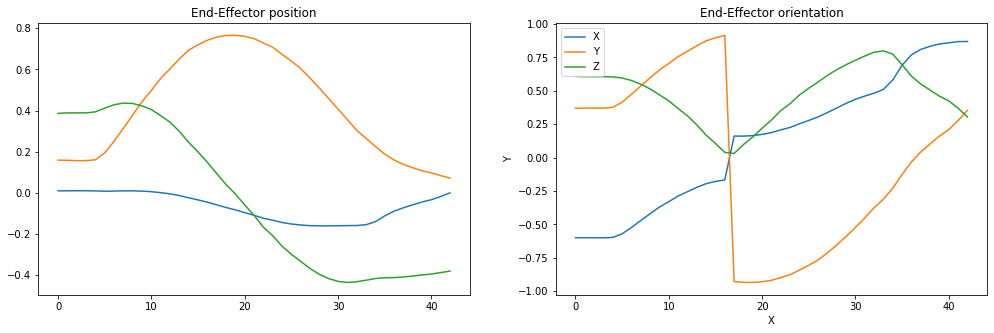

In [160]:
# f = plt.figure(figsize=[10.0, 5.0])
# ax = f.add_subplot(111)
# # ax = plt.axes(projection='3d')
# ax.plot(y_test[:,0])
# ax.plot(y_test[:,1])
# ax.plot(y_test[:,2])
# plt.show()
# f = plt.figure(figsize=[10.0, 5.0])
# ax = f.add_subplot(111)
# # ax = plt.axes(projection='3d')
# ax.plot(y_test[:,3])
# ax.plot(y_test[:,4])
# ax.plot(y_test[:,5])

f = plt.figure(figsize=[17.0, 5.0])

ax = f.add_subplot(121)
ax.plot(y_temp[:,0:3])
ax.set_title('End-Effector position');
ax = f.add_subplot(122)
ax.plot(y_temp[:,3:6])
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_title('End-Effector orientation');
ax.legend(('X','Y','Z'));
# plt.savefig('Error.png')
plt.show()
plt.close('all')

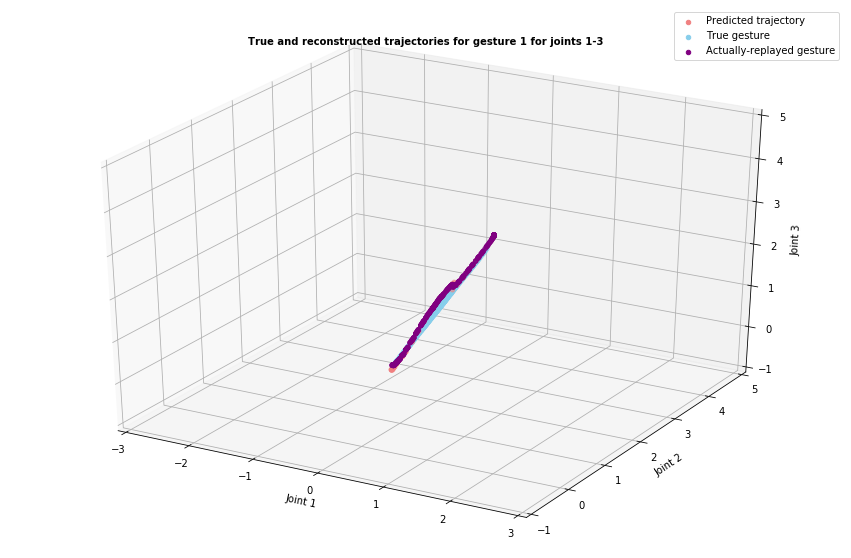

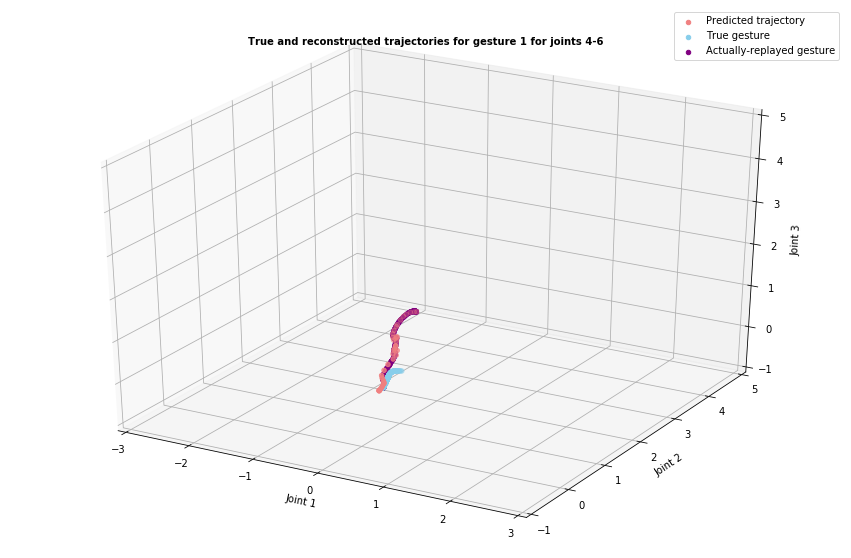

In [48]:
# def show_actual_trajectory(y, y_test, setskipval):
setskipval = 1


# filename = "C:\\Users\\jmoln\\AppData\\LocalLow\\DefaultCompany\\NonAnthroHandsUserStudy\\y_poss6s300_end_effectorPlayback.csv"
# # Import data from csvs
# joints_raw = pd.read_csv(filename)
# joint_data = joints_raw.to_numpy()

# joint_data = joint_data[...,1:7]

# pred_raw = pd.read_csv('PredJointAngles_for_TrainAllbut'+str(setskipval)+'_alphaval_'+str(alphaval)+'.csv')
pred_raw = pd.read_csv('PredJointAngles_for_Train'+str(setskipval)+'_leaveoneout_10_alphaval_0.01.csv')
pred_data = pred_raw.to_numpy()

# true_data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\corrected_positions_"+str(set_num)+".csv")
true_raw = pd.read_csv("C:\\Users\\jmoln\\AppData\\LocalLow\\DefaultCompany\\NonAnthroHandsUserStudy\\y_poss6s300_JointMotion_1.csv")
true_data = true_raw.to_numpy()
true_data = true_data[...,1:7]

new_raw = pd.read_csv("C:\\Users\\jmoln\\AppData\\LocalLow\\DefaultCompany\\NonAnthroHandsUserStudy\\y_poss6s300_JointMotion_2.csv")
new_data = new_raw.to_numpy()
new_data = new_data[80:-1,1:7]

labels=('1-3','4-6')

for i in range(2):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks
    fig.patch.set_visible(True)
    ax = plt.axes(projection='3d')
    ax.axis('on')
#     ax.view_init(-140, 20)
    ax.scatter(pred_data[:].T[3*i+0], pred_data[:].T[3*i+1], pred_data[:].T[3*i+2],c='lightcoral',label='Predicted trajectory')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
    ax.scatter(true_data[:].T[3*i+0], true_data[:].T[3*i+1], true_data[:].T[3*i+2],c='skyblue',label='True gesture')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
    ax.scatter(new_data[:].T[3*i+0] , new_data[:].T[3*i+1] , new_data[:].T[3*i+2] ,c='purple',label='Actually-replayed gesture') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
    ax.legend()

    
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,5)
    ax.set_zlim(-1,5)
    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')
    ax.set_title("True and reconstructed trajectories for gesture "+str(setskipval)+" for joints "+labels[i], fontsize=10, fontweight="bold")

    plt.show()
#     plt.savefig('Pred_vs_Actual_'+labels[i]+'_Train'+str(setskipval)+'_leaveoneout_10_alphaval_0.01.png') 
#     img = Image.open(r'Pred_vs_Actual_'+labels[i]+'_Train'+str(setskipval)+'_leaveoneout_10_alphaval_0.01.png')  
#     left = 220
#     top = 80
#     right = 980
#     bottom = 640
#     img_res = img.crop((left, top, right, bottom)) 
#     img_res.save('Pred_vs_Actual_'+labels[i]+'_Train'+str(setskipval)+'_leaveoneout_10_alphaval_0.01.png') 
#     plt.close('all')

In [24]:
pred_raw.to_numpy().shape

(41, 6)

In [229]:
temp = range(10)

In [231]:
temp

range(0, 10)